<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs_on_Multiple_timescale_dynamics/blob/main/Examples/Example1_2x2exact_sol_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving a 2x2 system by PINN (Comparing PINN with the exact solution to obtain the error).
$$
\begin{aligned}
\frac{dx}{dt} =& \mu  (- x + y^2),\\
\frac{dy}{dt} =& - 2  y,
\end{aligned}
$$
where $\mu$ is a large number.

In another code, I have the errors obtained by odeint. I want to have a separate code with errors to compare the errors obtained by PINNs with the errors obtained by odeint to see which one works better.

Epoch 0, Loss: 61.770668029785156
Epoch 1000, Loss: 3.159071922302246
Epoch 2000, Loss: 2.9956750869750977
Epoch 3000, Loss: 7.675988674163818
Epoch 4000, Loss: 3.382260322570801
Epoch 5000, Loss: 3.224247932434082
Epoch 6000, Loss: 3.0678350925445557
Epoch 7000, Loss: 2.918135404586792
Epoch 8000, Loss: 3.8129220008850098
Epoch 9000, Loss: 3.1828670501708984
Epoch 10000, Loss: 2.9142909049987793
Epoch 11000, Loss: 3.24362850189209
Epoch 12000, Loss: 3.0830326080322266
Epoch 13000, Loss: 2.845470905303955
Epoch 14000, Loss: 3.132307529449463
Epoch 15000, Loss: 2.90848970413208
Epoch 16000, Loss: 3.343242883682251
Epoch 17000, Loss: 3.6134517192840576
Epoch 18000, Loss: 3.082477331161499
Epoch 19000, Loss: 3.252476692199707
Epoch 20000, Loss: 3.555159091949463
Epoch 21000, Loss: 4.602400779724121
Epoch 22000, Loss: 2.4376583099365234
Epoch 23000, Loss: 1.4180861711502075
Epoch 24000, Loss: 0.3234492838382721
Epoch 25000, Loss: 0.41070327162742615
Epoch 26000, Loss: 0.530549943447113
Epo

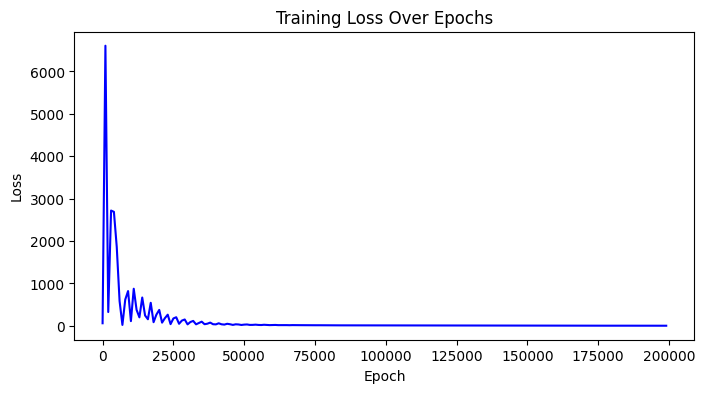

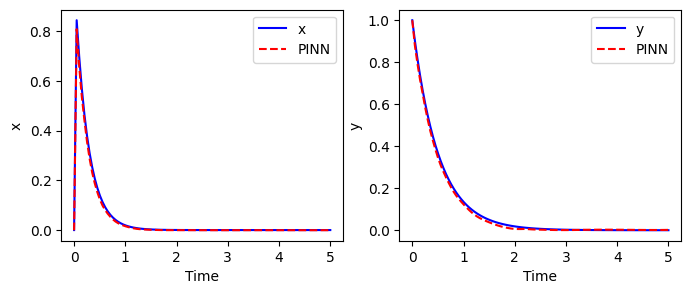

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# define ODEs
def NewSystem(y, t, mu):
    x, y = y
    dxdt = mu * (- x + y**2)
    dydt = - 2 * y
    return [dxdt, dydt]

# Exact solution for the new system
def ExactSolution(t, mu, x0, y0):
    x_real = (mu * y0**2 / (-4 + mu)) * (np.exp(-4 * t) - np.exp(-mu * t)) + x0 * np.exp(-mu * t)
    y_real = y0 * np.exp(-2 * t)
    return x_real, y_real

x0 = 0
y0 = 1
t = np.linspace(0, 5, 100)
mu = 100

# Exact solution
x_real, y_real = ExactSolution(t, mu, x0, y0)

# Transform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, t):
        t = input_transform(t)
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def loss_func(model, t_tensor, x_real, y_real, x0, y0, x_T, y_T, mu, random_points=10):
    t_tensor.requires_grad = True
    pred = model(t_tensor)
    x_pred, y_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]

    residual1 = dx_dt - mu * (- x_pred + y_pred**2)
    residual2 = dy_dt + 2 * y_pred
    init_loss = torch.square(x_pred[0] - x0) + torch.square(y_pred[0] - y0)
    physics_loss = torch.mean(residual1**2 + residual2**2)

    random_indices = torch.randint(0, x_real.shape[0], (random_points,))
    data_loss = torch.mean((x_pred[random_indices] - x_real[random_indices])**2 +
                           (y_pred[random_indices] - y_real[random_indices])**2)

    boundary_loss = torch.square(x_pred[-1] - x_T) + torch.square(y_pred[-1] - y_T)

    total_loss = physics_loss + 10*init_loss + 10*boundary_loss + 10*data_loss

    return total_loss

if __name__=='__main__':
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_values = []
    epoch_num = 200000
    for epoch in range(epoch_num):
      loss = loss_func(model, t_tensor, x_real_tensor, y_real_tensor, x0, y0, x_real[-1], y_real[-1], mu, random_points=10)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f'Epoch {epoch}, Loss: {loss.item()}')
      loss_values.append(loss.item())

    plt.figure(figsize=(8, 4))
    plt.plot(range(0, epoch_num, 1000), loss_values[:epoch_num//1000], 'b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

    # model evaluation
    model.eval()
    with torch.no_grad():
        x_pred, y_pred = model(t_tensor).numpy().T

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(t, x_real, 'b-', label='x')
    plt.plot(t, x_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(t, y_real, 'b-', label='y')
    plt.plot(t, y_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()


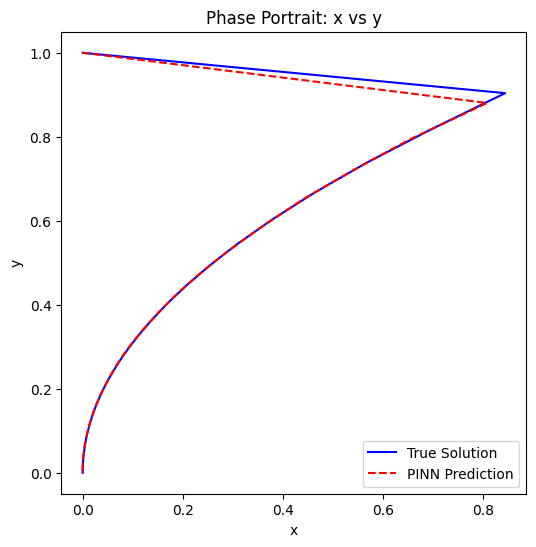

In [4]:
plt.figure(figsize=(6, 6))
plt.plot(x_real, y_real, 'b-', label='True Solution')
plt.plot(x_pred, y_pred, 'r--', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Portrait: x vs y')
plt.legend()
plt.show()